<a href="https://colab.research.google.com/github/SLy-Precision/Player-Detection-and-Team-Performance-Prediction/blob/main/04_AEGIS_Simulations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🤖 🔮 AEGIS Simulations 🧪 🎰

## ⚽ Once we did the scouting using advanced metrics (KPI's) now its time to fine-tunning teams with the new player in roster, here we are gonna get the proyections of performance of Club America with these additions 🕹️

### Antonio Guerrero

In [1]:
# Lets import the libraries we are gonna use 🐍

# Statsbomb api and more
!pip install --quiet statsbombpy
!pip install --quiet mplsoccer
!pip install --quiet highlight_text
!pip install --quiet xgboost

# Libraries for the data manipulation and plot
from statsbombpy import sb
from tqdm import tqdm
import pandas as pd
from mplsoccer import VerticalPitch, Pitch, Sbapi
from highlight_text import ax_text, fig_text
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import seaborn as sns
import numpy as np
from collections import defaultdict
from collections import Counter
from itertools import groupby
from mplsoccer import Pitch
import random

# Machine Learning

from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.utils.class_weight import compute_sample_weight

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.4/86.4 kB 6.2 MB/s eta 0:00:00


In [2]:
# Access to drive and files

from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/My Drive/Proyect_Hackathon/'

# Data needed

df_AEGIS_tunning = pd.read_csv(path + 'AEGIS_tunning_last_season.csv')
df_AEGIS_map = pd.read_csv(path + 'AEGIS_data.csv')
df= pd.read_csv(path + 'Full_Dataset_2021-2025.csv')

Mounted at /content/drive


In [4]:
id_america = 1229
team_name_prefix = 'club_america'

### 🤼‍♀ Analysis of Substitutions

In [5]:
array_recommendations = [10846,5738,27904]
array_replaced = [30944,35690,29265]

--- Counting Events for Players to be Replaced (Context: Team ID 1229) ---
Player ID 30944: 2545 events
Player ID 35690: 3119 events
Player ID 29265: 3534 events

--- Counting Events for Recommended Players (Context: All Teams) ---
Player ID 10846: 2398 events
Player ID 5738: 2931 events
Player ID 27904: 7107 events

--- Generating Comparison Charts ---
Chart saved: comparison_player_30944_vs_10846.png


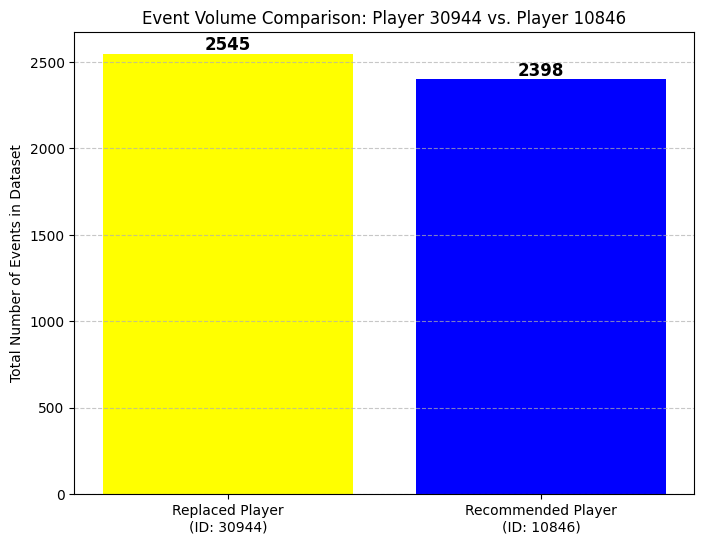

Chart saved: comparison_player_35690_vs_5738.png


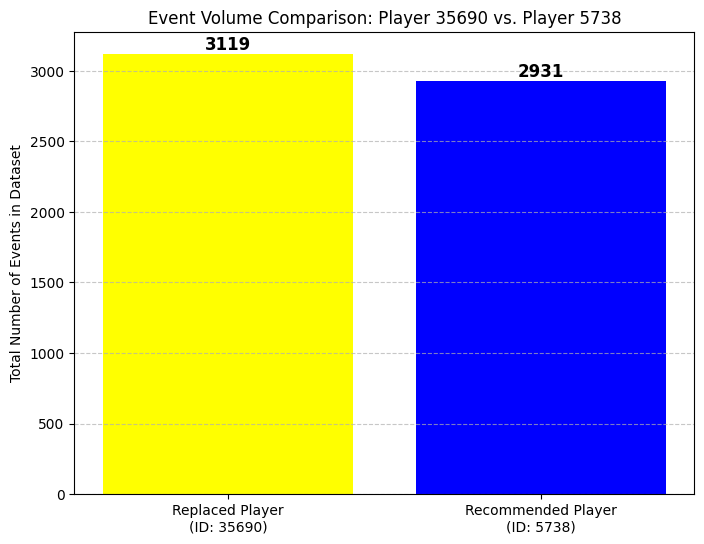

Chart saved: comparison_player_29265_vs_27904.png


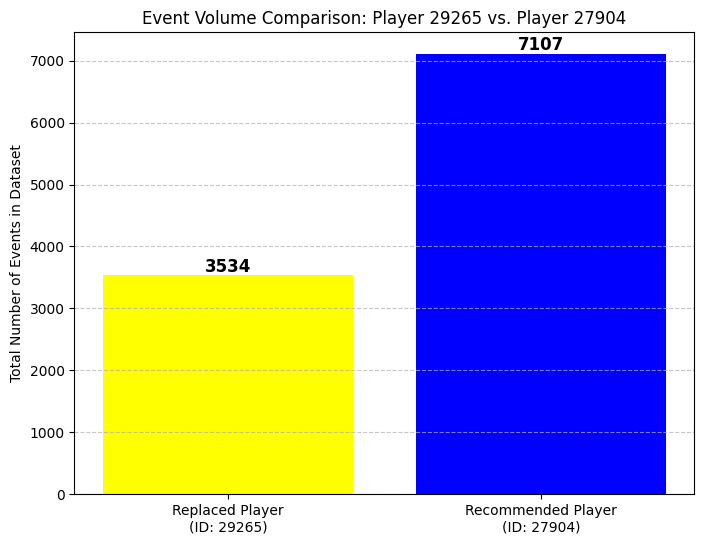

In [6]:
# DATA PREPARATION
df_AEGIS_tunning['team_id'] = np.where(
    df_AEGIS_tunning['IsHomeTeam'] == 1,
    df_AEGIS_tunning['home_team_id'],
    df_AEGIS_tunning['away_team_id']
)


# ANALYSIS: COUNT EVENTS
df_america = df_AEGIS_tunning[df_AEGIS_tunning['team_id'] == id_america]
replaced_player_events = {}
recommended_player_events = {}

print(f"--- Counting Events for Players to be Replaced (Context: Team ID {id_america}) ---")
for player_id in array_replaced:
    count = df_america[df_america['playerId'] == player_id].shape[0]
    replaced_player_events[player_id] = count
    print(f"Player ID {player_id}: {count} events")

print("\n--- Counting Events for Recommended Players (Context: All Teams) ---")
for player_id in array_recommendations:
    count = df_AEGIS_tunning[df_AEGIS_tunning['playerId'] == player_id].shape[0]
    recommended_player_events[player_id] = count
    print(f"Player ID {player_id}: {count} events")


# VISUALIZATION: BAR CHARTS

print("\n--- Generating Comparison Charts ---")
for replaced_id, recommended_id in zip(array_replaced, array_recommendations):
    replaced_count = replaced_player_events.get(replaced_id, 0)
    recommended_count = recommended_player_events.get(recommended_id, 0)

    players_labels = [f'Replaced Player\n(ID: {replaced_id})', f'Recommended Player\n(ID: {recommended_id})']
    event_counts = [replaced_count, recommended_count]

    plt.figure(figsize=(8, 6))
    bars = plt.bar(players_labels, event_counts, color=['#ffff00', '#0000ff'])

    plt.ylabel('Total Number of Events in Dataset')
    plt.title(f'Event Volume Comparison: Player {replaced_id} vs. Player {recommended_id}')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom', ha='center', fontsize=12, fontweight='bold')

    filename = f'comparison_player_{replaced_id}_vs_{recommended_id}.png'
    plt.savefig(filename)
    print(f"Chart saved: {filename}")

    plt.show()

    plt.close()

### Functions and pre-charged models we are gonna use:

In [16]:
# Here we put all the functions for the simulations (most of them from the previous notebooks)

# Lets precharge the function of context to faster compilation of simulations

def create_and_save_full_context_df(df, seq_len=5, output_filename='df_with_context0.pkl'):
    """
    Performs the heavy lifting of creating the sequential context for the entire dataset
    and saves it to a file. This only needs to be run once.
    """
    print(f"--- 🦾 Starting Heavy Pre-processing for all {len(df)} events... ---")
    print("This will take a long time, but you only have to do it once!")

    # Define the features that will form the context
    context_features = [
        'EventTypeId', 'X_norm', 'Y_norm', 'IsHomeTeam', 'IsAccurate', 'IsGoal',
        'TimeDelta', 'minute_norm', 'HomeScore_norm', 'AwayScore_norm'
    ]

    # We work on a copy to be safe
    data = df.copy()

    # The slow loop to create the "rear-view mirror"
    for i in range(1, seq_len + 1):
        for feature in context_features:
            new_col_name = f'c{i}_{feature}'
            print(f"Creating context feature: {new_col_name}...")
            # Group by match and shift to look back in time
            data[new_col_name] = data.groupby('matchId')[feature].shift(i)

    # Clean up rows at the beginning of matches that don't have a full 5-event history
    data.dropna(subset=[f'c{seq_len}_{context_features[0]}'], inplace=True)

    # Save the processed DataFrame using the efficient pickle format
    print(f"\nSaving the context-rich DataFrame to '{output_filename}'...")
    data.to_pickle(output_filename)

    print(f"✅ Pre-processing complete! Your data is saved and ready for fast training.")
    return data

# Function to create hibrid dfs

def create_hybrid_dataset(base_df, team_id, player_out_id, player_in_id):
    """
    Creates a hybrid dataset for fine-tuning by replacing one player with another.

    Args:
        base_df (pd.DataFrame): The full, original DataFrame with all event data.
        team_id (int): The unique ID of the team to modify.
        player_out_id (int): The ID of the player to remove from the team.
        player_in_id (int): The ID of the player to add to the team.

    Returns:
        pd.DataFrame: A new DataFrame ready for context creation and fine-tuning.
    """
    print(f"--- Creating Hybrid Dataset for Team ID: {team_id} ---")
    print(f"  - Removing Player ID: {player_out_id}")
    print(f"  - Adding Player ID: {player_in_id}\n")

    # Create a 'team_id' column for accurate event ownership
    if 'team_id' not in base_df.columns:
        print("Creating 'team_id' column...")
        base_df['team_id'] = np.where(
            base_df['IsHomeTeam'] == 1,
            base_df['home_team_id'],
            base_df['away_team_id']
        )

    # Isolate all events from the target team
    df_team = base_df[base_df['team_id'] == team_id]
    print(f"Original event count for team {team_id}: {len(df_team)}")

    # Remove all events of the player who is leaving
    df_team_without_player = df_team[df_team['playerId'] != player_out_id]
    print(f"Event count after removing player {player_out_id}: {len(df_team_without_player)}")

    # Get all events of the player who is joining from the entire dataset
    df_player_in = base_df[base_df['playerId'] == player_in_id]
    print(f"Found {len(df_player_in)} events for incoming player {player_in_id}")

    # Concatenate the two DataFrames to create the final hybrid dataset
    df_hybrid = pd.concat([df_team_without_player, df_player_in], ignore_index=True)
    print(f"\n✅ Final hybrid dataset created with {len(df_hybrid)} total events.\n")

    return df_hybrid

# Functions to fine tunning

def prepare_features_and_target(context_df, target_col='EventTypeId_mapped'):
    """
    Prepares the features (X) and target (y) directly from a
    context DataFrame. It does no mapping here.
    """
    data = context_df.copy()

    # 'y' is simply the target column, which should already be pre-processed.
    y = data[target_col]

    # 'X' are all context features that start with 'c'.
    context_cols = [col for col in data.columns if col.startswith('c')]
    X = data[context_cols]

    return X, y


def prepare_features_with_prediction(context_df, event_type_model, target_col):
    """
    Prepares features from a context_df and adds the
    cascaded prediction from a previously trained model.
    """
    # Use the new, simpler base function
    X, y_target = prepare_features_and_target(context_df, target_col=target_col)

    print(f"Generating EventType predictions for {len(X)} rows...")
    # Ensure feature names match what the model was trained on to avoid errors
    X_for_pred = X[event_type_model.get_booster().feature_names]
    predicted_event_type = event_type_model.predict(X_for_pred)
    X['predicted_EventTypeId'] = predicted_event_type

    return X, y_target

def finetune_classifier_player_replacement(train_df, val_df, base_model_path, new_model_path,
                                           is_goal_model=False, event_type_model=None,
                                           num_classes=None):
    """
    Fine-Tuning function for Classifiers, designed for player replacement.
    It accepts specific training and validation DataFrames that have already been pre-processed.
    """
    print(f"\n--- 🦾 Starting Player Replacement Fine-Tuning for: {new_model_path} ---")

    # --- KEY CHANGE: Determine the correct target column ---
    if is_goal_model:
        target_col = 'IsGoal'
    elif event_type_model:
        target_col = 'IsAccurate'
    else:
        target_col = 'EventTypeId_mapped'  # Use the already pre-processed and mapped column

    # Prepare data using the simplified functions (no internal mapping)
    if event_type_model:
        X_train, y_train = prepare_features_with_prediction(train_df, event_type_model, target_col)
        X_val, y_val = prepare_features_with_prediction(val_df, event_type_model, target_col)
    else:
        # The mapping parameter is no longer passed here
        X_train, y_train = prepare_features_and_target(train_df, target_col)
        X_val, y_val = prepare_features_and_target(val_df, target_col)

    # Logic for the specialized goal model (remains the same)
    if is_goal_model:
        # Note: This logic uses the original 'EventTypeId' column for filtering, which is correct.
        train_mask = (train_df['EventTypeId'] == 16)
        X_train, y_train = X_train[train_mask], y_train[train_mask]
        val_mask = (val_df['EventTypeId'] == 16)
        X_val, y_val = X_val[val_mask], y_val[val_mask]

    # The weight calculation will now work because y_train is the correct data type (categorical/numeric).
    sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

    # Initialize the model (remains the same)
    finetuned_model = xgb.XGBClassifier(
        objective='multi:softprob' if num_classes else 'binary:logistic',
        num_class=num_classes if num_classes else None,
        eval_metric='mlogloss' if num_classes else 'logloss',
        learning_rate=0.01, n_estimators=1000, early_stopping_rounds=20,
        use_label_encoder=False, random_state=42
    )

    print("Starting fine-tuning...")
    # The .fit() method now receives the correct and compatible data
    finetuned_model.fit(X_train, y_train,
                        eval_set=[(X_val, y_val)],
                        verbose=100,
                        sample_weight=sample_weights,
                        xgb_model=base_model_path # Path to the pre-trained base model
                       )

    finetuned_model.save_model(new_model_path)
    print(f"✅ Fine-tuned model saved to: {new_model_path}")
    return finetuned_model


def finetune_regressor_player_replacement(train_df, val_df, base_model_path, new_model_path, target_col, event_type_model):
    """
    CORRECTED Fine-Tuning for Regressors, designed for player replacement.
    """
    print(f"\n--- 🦾 Starting Player Replacement Fine-Tuning for: {new_model_path} ---")

    # Prepare data using the corrected functions
    X_train, y_train = prepare_features_with_prediction(train_df, event_type_model, target_col)
    X_val, y_val = prepare_features_with_prediction(val_df, event_type_model, target_col)

    if target_col == 'TimeDelta':
        y_train, y_val = np.log1p(y_train), np.log1p(y_val)

    # Initialize the model
    finetuned_model = xgb.XGBRegressor(
        objective='reg:squarederror', eval_metric='rmse', learning_rate=0.01,
        n_estimators=500, early_stopping_rounds=20, random_state=42
    )

    print("Starting fine-tuning...")
    finetuned_model.fit(X_train, y_train,
                        eval_set=[(X_val, y_val)],
                        verbose=100,
                        xgb_model=base_model_path
                       )

    finetuned_model.save_model(new_model_path)
    print(f"✅ Fine-tuned model saved to: {new_model_path}")
    return finetuned_model

In [8]:
# Here we charge the pre-trained models before and create the ensembled model

# Lets charge all the models

# --- 1: Load the Trained Model from the JSON File ---
print("Step 1: Loading the trained AEGIS EventTypeModel from file... 📂")

# Create a new, empty XGBoost model instance
event_type_model = xgb.XGBClassifier()

model_filename = path + 'event_type_model1.json'

# Load the trained state into the empty model
event_type_model.load_model(model_filename)

print("✅ EventTypeModel loaded successfully!")

# --- 2: Load the Trained Model from the JSON File ---
print("Step 2: Loading the trained AEGIS AccuracyModel from file... 📂")

# Create a new, empty XGBoost model instance
accuracy_model = xgb.XGBClassifier()

model_filename = path + 'accuracy_model1.json'

# Load the trained state into the empty model
accuracy_model.load_model(model_filename)

print("✅ AccuracyModel loaded successfully!")

# --- 3: Load the Trained Model from the JSON File ---

print("Step 3: Loading the trained AEGIS GoalModel from file... 📂")

# Create a new, empty XGBoost model instance
goal_model = xgb.XGBClassifier()

model_filename = path + 'goal_model0.json'

# Load the trained state into the empty model
goal_model.load_model(model_filename)

print("✅ GoalModel loaded successfully!")

# --- 4: Load the Trained Model from the JSON File ---

print("Step 4: Loading the trained AEGIS XModel from file... 📂")

# Create a new, empty XGBoost model instance
# Use XGBRegressor for regression models
x_location = xgb.XGBRegressor()

model_filename = path + 'x_model0.json'

# Load the trained state into the empty model
x_location.load_model(model_filename)

print("✅ XModel loaded successfully!")

# --- 4: Load the Trained Model from the JSON File ---

print("Step 5: Loading the trained AEGIS YModel from file... 📂")

# Create a new, empty XGBoost model instance
# Use XGBRegressor for regression models
y_location = xgb.XGBRegressor()

model_filename = path + 'y_model0.json'

# Load the trained state into the empty model
y_location.load_model(model_filename)

print("✅ YModel loaded successfully!")

# --- 5: Load the Trained Model from the JSON File ---

print("Step 6: Loading the trained AEGIS TimeDeltaModel from file... 📂")

# Create a new, empty XGBoost model instance
# Use XGBRegressor for regression models
timedelta_model = xgb.XGBRegressor()

model_filename = path + 'timedelta_model0.json'

# Load the trained state into the empty model
timedelta_model.load_model(model_filename)

Step 1: Loading the trained AEGIS EventTypeModel from file... 📂
✅ EventTypeModel loaded successfully!
Step 2: Loading the trained AEGIS AccuracyModel from file... 📂
✅ AccuracyModel loaded successfully!
Step 3: Loading the trained AEGIS GoalModel from file... 📂
✅ GoalModel loaded successfully!
Step 4: Loading the trained AEGIS XModel from file... 📂
✅ XModel loaded successfully!
Step 5: Loading the trained AEGIS YModel from file... 📂
✅ YModel loaded successfully!
Step 6: Loading the trained AEGIS TimeDeltaModel from file... 📂


In [9]:
# Mapping

# Get all unique event types from your final, cleaned DataFrame

all_event_types = sorted(df_AEGIS_map['EventTypeId'].unique())


# Create the class mapping based on the known event types
class_mapping = {original_id: new_id for new_id, original_id in enumerate(all_event_types)}


print("--- Class Mapping Re-created based on known event types ---")
print(f"Total unique event types (classes) based on base model: {len(class_mapping)}")
print("\nThis is your 'translator':")
print(class_mapping)

event_name_map = {
    18: 'Half Start',
    30: 'Pass',
    42: 'Ball Receipt*',
    43: 'Carry',
    17: 'Pressure',
    14: 'Dribble',
    4:  'Duel',
    9:  'Clearance',
    3:  'Dispossessed',
    2:  'Ball Recovery',
    6:  'Block',
    22: 'Foul Committed',
    21: 'Foul Won',
    16: 'Shot',
    23: 'Goal Keeper',
    39: 'Dribbled Past',
    38: 'Miscontrol',
    27: 'Player Off',
    26: 'Player On',
    10: 'Interception',
    33: '50/50',
    34: 'Half End',
    40: 'Injury Stoppage',
    19: 'Substitution',
    36: 'Tactical Shift',
    24: 'Bad Behaviour',
    41: 'Referee Ball-Drop',
    37: 'Error',
    28: 'Shield',
    8:  'Offside',
    25: 'Own Goal For',
    20: 'Own Goal Against'
}

num_classes = len(class_mapping)

--- Class Mapping Re-created based on known event types ---
Total unique event types (classes) based on base model: 32

This is your 'translator':
{np.int64(2): 0, np.int64(3): 1, np.int64(4): 2, np.int64(6): 3, np.int64(8): 4, np.int64(9): 5, np.int64(10): 6, np.int64(14): 7, np.int64(16): 8, np.int64(17): 9, np.int64(18): 10, np.int64(19): 11, np.int64(20): 12, np.int64(21): 13, np.int64(22): 14, np.int64(23): 15, np.int64(24): 16, np.int64(25): 17, np.int64(26): 18, np.int64(27): 19, np.int64(28): 20, np.int64(30): 21, np.int64(33): 22, np.int64(34): 23, np.int64(36): 24, np.int64(37): 25, np.int64(38): 26, np.int64(39): 27, np.int64(40): 28, np.int64(41): 29, np.int64(42): 30, np.int64(43): 31}


## ⚠️ Simulation Player 1:

In [10]:
# We take the first

id_america = 1229

player_enter0 = array_recommendations[0]
player_out0 = array_replaced[0]

print(f"Player entering: {player_enter0}")
print(f"Player leaving: {player_out0}")

# First case out A.Dávila and goes in Murillo Roma

Player entering: 10846
Player leaving: 30944


In [11]:
# We run this just once per player

# Lets make the hybrid df with the two players

data_for_player0 = create_hybrid_dataset(df_AEGIS_tunning, id_america, player_out0, player_enter0)

# Then we create that df with context

data_for_player0 = create_and_save_full_context_df(data_for_player0)

# Save the df in our unit

data_for_player0.to_pickle(path + 'data_for_player0.pkl')

--- Creating Hybrid Dataset for Team ID: 1229 ---
  - Removing Player ID: 30944
  - Adding Player ID: 10846

Original event count for team 1229: 84213
Event count after removing player 30944: 81668
Found 2398 events for incoming player 10846

✅ Final hybrid dataset created with 84066 total events.

--- 🦾 Starting Heavy Pre-processing for all 84066 events... ---
This will take a long time, but you only have to do it once!
Creating context feature: c1_EventTypeId...
Creating context feature: c1_X_norm...
Creating context feature: c1_Y_norm...
Creating context feature: c1_IsHomeTeam...
Creating context feature: c1_IsAccurate...
Creating context feature: c1_IsGoal...
Creating context feature: c1_TimeDelta...
Creating context feature: c1_minute_norm...
Creating context feature: c1_HomeScore_norm...
Creating context feature: c1_AwayScore_norm...
Creating context feature: c2_EventTypeId...
Creating context feature: c2_X_norm...
Creating context feature: c2_Y_norm...
Creating context feature: 

In [13]:
# ⚠️ 🔴 Lets call the df 🚨 ⚠️

# 1. Cargar el DataFrame con el contexto del jugador
df_for_player0 = pd.read_pickle(path + 'data_for_player0.pkl')

# 2. DEFINIR EL UNIVERSO DE EVENTOS CORRECTO (EL QUE EL MODELO CONOCE)

all_event_types_from_master = sorted(df_AEGIS_map['EventTypeId'].unique())
#    ...y quitamos el evento 20, que sabemos que el modelo no conoce.
event_types_for_model = [event for event in all_event_types_from_master if event != 20]

# 3. Crear el class_mapping y num_classes a partir de esta lista corregida de 31 eventos
class_mapping = {original_id: new_id for new_id, original_id in enumerate(event_types_for_model)}
num_classes = len(class_mapping)

print("--- Mapeo Final y Correcto Creado ---")
print(f"Total de clases que el modelo entiende: {num_classes}") # Debe imprimir 31

# 4. Aplicar el mapeo a todo el DataFrame ANTES de dividirlo
df_for_player0['EventTypeId_mapped'] = df_for_player0['EventTypeId'].map(class_mapping)

# 5. Convertir la nueva columna a tipo categórico con todas las clases posibles
all_possible_classes = list(class_mapping.values())
df_for_player0['EventTypeId_mapped'] = pd.Categorical(df_for_player0['EventTypeId_mapped'], categories=all_possible_classes)

# 6. Eliminar filas donde el mapeo podría haber fallado (si hubiera eventos extraños)
df_for_player0.dropna(subset=['EventTypeId_mapped'], inplace=True)
df_for_player0['EventTypeId_mapped'] = df_for_player0['EventTypeId_mapped'].astype(int)

# 7. Ahora, dividir el DataFrame ya preparado en entrenamiento y validación
all_match_ids = df_for_player0['matchId'].unique()
train_ids, val_ids = train_test_split(all_match_ids, test_size=0.2, random_state=42)

train_df = df_for_player0[df_for_player0['matchId'].isin(train_ids)]
val_df = df_for_player0[df_for_player0['matchId'].isin(val_ids)]

print(f"\nDivisión completa: {len(train_df)} filas de entrenamiento, {len(val_df)} filas de validación.")

--- Mapeo Final y Correcto Creado ---
Total de clases que el modelo entiende: 31

División completa: 62985 filas de entrenamiento, 20711 filas de validación.


In [14]:
finetuned_event_type_model_player0 = finetune_classifier_player_replacement(
    train_df=train_df,
    val_df=val_df,
    base_model_path=path + 'event_type_model1.json',
    new_model_path=path + 'finetuned_event_type_model_player0.json',
    is_goal_model=False,
    event_type_model=None,
    num_classes=num_classes
)

# 7 min


--- 🦾 Starting Player Replacement Fine-Tuning for: /content/drive/My Drive/Proyect_Hackathon/finetuned_event_type_model_player0.json ---
Starting fine-tuning...
[0]	validation_0-mlogloss:5.09344
[100]	validation_0-mlogloss:2.27830
[200]	validation_0-mlogloss:1.80651
[300]	validation_0-mlogloss:1.59469
[400]	validation_0-mlogloss:1.47710
[499]	validation_0-mlogloss:1.40696
✅ Fine-tuned model saved to: /content/drive/My Drive/Proyect_Hackathon/finetuned_event_type_model_player0.json


In [17]:
# Save the model

finetuned_event_type_model_player0.save_model(path + 'finetuned_event_type_model_player0.json')

In [18]:
# Precharge (just in case)

finetuned_event_type_model_player0.load_model(path + 'finetuned_event_type_model_player0.json')

In [19]:
# 🎯 FineTunning for Accuracy

finetuned_accuracy_model_player0 = finetune_classifier_player_replacement(
    train_df=train_df,
    val_df=val_df,
    base_model_path=path + 'accuracy_model1.json',
    new_model_path=path + 'finetuned_accuracy_model_player0.json',
    event_type_model=finetuned_event_type_model_player0
)


--- 🦾 Starting Player Replacement Fine-Tuning for: /content/drive/My Drive/Proyect_Hackathon/finetuned_accuracy_model_player0.json ---
Generating EventType predictions for 62985 rows...
Generating EventType predictions for 20711 rows...
Starting fine-tuning...
[0]	validation_0-logloss:0.43203
[100]	validation_0-logloss:0.34643
[200]	validation_0-logloss:0.34297
[202]	validation_0-logloss:0.34299
✅ Fine-tuned model saved to: /content/drive/My Drive/Proyect_Hackathon/finetuned_accuracy_model_player0.json


In [20]:
# Save the model

finetuned_accuracy_model_player0.save_model(path + 'finetuned_accuracy_model_player0.json')

In [21]:
# Precharge the model (Just in case)

finetuned_accuracy_model_player0.load_model(path + 'finetuned_accuracy_model_player0.json')

In [22]:
# ⚽ FineTunning for Goal Model

finetuned_goal_model_player0 = finetune_classifier_player_replacement(
    train_df=train_df,
    val_df=val_df,
    base_model_path=path + 'goal_model0.json',
    new_model_path=path + 'finetuned_goal_model_player0.json',
    is_goal_model=True,
    event_type_model=finetuned_event_type_model_player0
)


--- 🦾 Starting Player Replacement Fine-Tuning for: /content/drive/My Drive/Proyect_Hackathon/finetuned_goal_model_player0.json ---
Generating EventType predictions for 62985 rows...
Generating EventType predictions for 20711 rows...
Starting fine-tuning...
[0]	validation_0-logloss:0.66002
[100]	validation_0-logloss:0.48566
[200]	validation_0-logloss:0.39462
[300]	validation_0-logloss:0.36019
[400]	validation_0-logloss:0.34463
[500]	validation_0-logloss:0.33301
[600]	validation_0-logloss:0.32765
[700]	validation_0-logloss:0.32336
[800]	validation_0-logloss:0.32233
✅ Fine-tuned model saved to: /content/drive/My Drive/Proyect_Hackathon/finetuned_goal_model_player0.json


In [23]:
# Save the model

finetuned_goal_model_player0.save_model(path + 'finetuned_goal_model_player0.json')

In [24]:
#  Precharge

finetuned_goal_model_player0.load_model(path + 'finetuned_goal_model_player0.json')

In [25]:
# 📏 FineTunning for X

finetuned_x_location_player0 = finetune_regressor_player_replacement(
    train_df=train_df,
    val_df=val_df,
    base_model_path=path + 'x_model0.json',
    new_model_path=path + 'finetuned_x_location_player0.json',
    target_col='X_norm',
    event_type_model=finetuned_event_type_model_player0
)


--- 🦾 Starting Player Replacement Fine-Tuning for: /content/drive/My Drive/Proyect_Hackathon/finetuned_x_location_player0.json ---
Generating EventType predictions for 62985 rows...
Generating EventType predictions for 20711 rows...
Starting fine-tuning...
[0]	validation_0-rmse:0.19105
[100]	validation_0-rmse:0.12724
[200]	validation_0-rmse:0.11410
[300]	validation_0-rmse:0.11102
[400]	validation_0-rmse:0.10984
[499]	validation_0-rmse:0.10924
✅ Fine-tuned model saved to: /content/drive/My Drive/Proyect_Hackathon/finetuned_x_location_player0.json


In [26]:
# Save the model

finetuned_x_location_player0.save_model(path + 'finetuned_x_location_player0.json')

In [27]:
# Precgagre jus in case we need

finetuned_x_location_player0.load_model(path + 'finetuned_x_location_player0.json')

In [28]:
# 📏 FineTunning for Y

finetuned_y_location_player0 = finetune_regressor_player_replacement(
    train_df=train_df,
    val_df=val_df,
    base_model_path=path + 'y_model0.json',
    new_model_path=path + 'finetuned_y_location_player0.json',
    target_col='Y_norm',
    event_type_model=finetuned_event_type_model_player0
)


--- 🦾 Starting Player Replacement Fine-Tuning for: /content/drive/My Drive/Proyect_Hackathon/finetuned_y_location_player0.json ---
Generating EventType predictions for 62985 rows...
Generating EventType predictions for 20711 rows...
Starting fine-tuning...
[0]	validation_0-rmse:0.22680
[100]	validation_0-rmse:0.16054
[200]	validation_0-rmse:0.14800
[300]	validation_0-rmse:0.14527
[400]	validation_0-rmse:0.14440
[499]	validation_0-rmse:0.14410
✅ Fine-tuned model saved to: /content/drive/My Drive/Proyect_Hackathon/finetuned_y_location_player0.json


In [29]:
# Save model

finetuned_y_location_player0.save_model(path + 'finetuned_y_location_player0.json')

In [30]:
# Precharge

finetuned_y_location_player0.load_model(path + 'finetuned_y_location_player0.json')

In [31]:
# ⏱️ FineTunning for TimeDelta

finetuned_timedelta_model_player0 = finetune_regressor_player_replacement(
    train_df=train_df,
    val_df=val_df,
    base_model_path=path + 'timedelta_model0.json',
    new_model_path=path + 'finetuned_timedelta_model_player0.json',
    target_col='TimeDelta',
    event_type_model=finetuned_event_type_model_player0
)


--- 🦾 Starting Player Replacement Fine-Tuning for: /content/drive/My Drive/Proyect_Hackathon/finetuned_timedelta_model_player0.json ---
Generating EventType predictions for 62985 rows...
Generating EventType predictions for 20711 rows...
Starting fine-tuning...
[0]	validation_0-rmse:0.62292
[100]	validation_0-rmse:0.55157
[200]	validation_0-rmse:0.53457
[300]	validation_0-rmse:0.52897
[400]	validation_0-rmse:0.52613
[499]	validation_0-rmse:0.52457
✅ Fine-tuned model saved to: /content/drive/My Drive/Proyect_Hackathon/finetuned_timedelta_model_player0.json


In [32]:
# Save the model

finetuned_timedelta_model_player0.save_model(path + 'finetuned_timedelta_model_player0.json')

In [33]:
# Precharge just in case

finetuned_timedelta_model_player0.load_model(path + 'finetuned_timedelta_model_player0.json')

In [55]:
# Next we construct these rules we said, so, for all before we use next functions

# Simulation Engine Functions

def create_context_for_prediction(event_history_df, seq_len, context_features):
    """
    Prepares the context from the last 'seq_len' events for a single prediction.
    CORRECTED to remove columns the base models were not trained on.
    """
    data = event_history_df.tail(seq_len).copy()
    for i in range(1, seq_len + 1):
        for feature in context_features:
            new_col_name = f'c{i}_{feature}'
            data[new_col_name] = data[feature].shift(i-1)

    final_context_row = data.tail(1).copy()


    # Add team IDs and other text columns to the list of features to drop
    features_to_drop = context_features + [
        'matchId', 'playerId', 'X', 'Y', 'minute', 'HomeScore', 'AwayScore', 'period',
        'home_team_id', 'away_team_id', 'home_team_name', 'away_team_name', 'team_id'
    ]

    # Check which of the columns to be dropped actually exist to prevent errors
    cols_to_drop_existing = [col for col in features_to_drop if col in final_context_row.columns]

    X = final_context_row.drop(columns=cols_to_drop_existing)
    return X


def simulate_full_match_v10(initial_context_df, all_models, target_dist, events_per_half=1600, seq_len=5, goal_threshold=0.65, realism_strength=0.7):
    """
    Simulates a full match combining the realism layer with "guaranteed reception" logic.
    (This function remains identical to your original version)
    """
    context_features = [
        'EventTypeId', 'X_norm', 'Y_norm', 'IsHomeTeam', 'IsAccurate', 'IsGoal',
        'TimeDelta', 'minute_norm', 'HomeScore_norm', 'AwayScore_norm'
    ]
    reverse_class_mapping = {v: k for k, v in all_models['class_mapping'].items()}
    simulated_events = []
    event_history = initial_context_df.copy()

    last_event = event_history.iloc[-1]
    home_score, away_score = 0, 0
    current_minute = last_event['minute']
    team_in_possession = last_event['IsHomeTeam']

    pass_id = 30
    ball_receipt_id = 42
    turnover_ids = [2, 10, 4, 33]

    force_next_event = None

    for period in [1, 2]:
        if period == 2: current_minute = 45.0

        for i in range(events_per_half):
            X_predict = create_context_for_prediction(event_history, seq_len, context_features)

            if force_next_event:
                predicted_event_type_original = force_next_event
                for original, mapped in all_models['class_mapping'].items():
                    if original == predicted_event_type_original:
                        predicted_event_type_mapped = mapped
                        break
                force_next_event = None
            else:
                event_type_proba = all_models['event_type'].predict_proba(X_predict)[0]
                adjusted_proba = np.copy(event_type_proba)
                for new_id, original_id in reverse_class_mapping.items():
                    if original_id == ball_receipt_id:
                        adjusted_proba[new_id] = 0
                        continue
                    target_p = target_dist.get(original_id, 0)
                    adjusted_proba[new_id] = (event_type_proba[new_id] * (1 - realism_strength)) + (target_p * realism_strength)

                if adjusted_proba.sum() > 0: adjusted_proba /= adjusted_proba.sum()
                else: adjusted_proba = np.ones(len(adjusted_proba)) / len(adjusted_proba)

                predicted_event_type_mapped = np.random.choice(len(adjusted_proba), p=adjusted_proba)
                predicted_event_type_original = reverse_class_mapping[predicted_event_type_mapped]

            X_predict['predicted_EventTypeId'] = predicted_event_type_mapped
            predicted_is_accurate = all_models['accuracy'].predict(X_predict)[0]

            if predicted_event_type_original == pass_id and predicted_is_accurate == 1:
                force_next_event = ball_receipt_id

            predicted_is_goal = 0
            if predicted_event_type_original == 16:
                goal_probability = all_models['goal'].predict_proba(X_predict)[0][1]
                if goal_probability > goal_threshold: predicted_is_goal = 1

            x_pred_mean = all_models['x_location'].predict(X_predict)[0]
            predicted_x_norm = np.random.normal(loc=x_pred_mean, scale=0.17)
            y_pred_mean = all_models['y_location'].predict(X_predict)[0]
            predicted_y_norm = np.random.normal(loc=y_pred_mean, scale=0.28)
            timedelta_pred_log_mean = all_models['timedelta'].predict(X_predict)[0]
            predicted_timedelta_log = np.random.normal(loc=timedelta_pred_log_mean, scale=0.44)
            predicted_timedelta = np.expm1(predicted_timedelta_log)

            if predicted_event_type_original in [30, 14, 38] and predicted_is_accurate == 0:
                if random.random() > 0.2: team_in_possession = 1 - team_in_possession
            elif predicted_event_type_original in turnover_ids:
                 team_in_possession = 1 - team_in_possession

            current_minute += predicted_timedelta / 60
            if predicted_is_goal == 1:
                if team_in_possession == 1: home_score += 1
                else: away_score += 1

            new_event = { 'period': period, 'minute': current_minute, 'EventTypeId': predicted_event_type_original,
                          'IsAccurate': int(predicted_is_accurate), 'IsGoal': int(predicted_is_goal),
                          'X': np.clip(predicted_x_norm, 0, 1) * 100, 'Y': np.clip(predicted_y_norm, 0, 1) * 100,
                          'TimeDelta': np.maximum(0, predicted_timedelta), 'HomeScore': home_score, 'AwayScore': away_score,
                          'IsHomeTeam': team_in_possession, 'playerId': -1, }
            simulated_events.append(new_event)

            new_history_row_data = new_event.copy()
            new_history_row_data.update({ 'X_norm': new_history_row_data['X'] / 100.0, 'Y_norm': new_history_row_data['Y'] / 100.0,
                                          'minute_norm': new_history_row_data['minute'] / 60.0,
                                          'HomeScore_norm': new_history_row_data['HomeScore'] / 10.0, 'AwayScore_norm': new_history_row_data['AwayScore'] / 10.0 })
            new_history_df = pd.DataFrame([new_history_row_data])
            for col in event_history.columns:
                if col not in new_history_df.columns: new_history_df[col] = event_history.iloc[-1][col]
            event_history = pd.concat([event_history, new_history_df[event_history.columns]], ignore_index=True)

    print(f"✅ Match Simulation Complete! Final Score: Home {int(home_score)} - {int(away_score)} Away")
    return pd.DataFrame(simulated_events), (home_score, away_score)

#  New Function for Player-Specific Simulation Analysis

def run_player_simulation_analysis(
    real_data_df,
    team_id_to_analyze,
    simulation_context_df,
    validation_match_ids,
    all_finetuned_models,
    n_matches_to_simulate=20,
    goal_threshold=0.55,
    realism_strength=0.65
):
    """
    This function runs multiple match simulations using fine-tuned player models
    and generates a performance report comparing simulated results to historical data.
    """
    print(f"--- 🚀 STARTING SIMULATION ANALYSIS FOR TEAM ID: {team_id_to_analyze} ---")

    # Calculate Real-World Metrics from the Last Season
    print("\n--- Calculating Real-World Performance Metrics... ---")
    real_team_matches = real_data_df[
        (real_data_df['home_team_id'] == team_id_to_analyze) |
        (real_data_df['away_team_id'] == team_id_to_analyze)
    ]
    real_match_ids = real_team_matches['matchId'].unique()
    num_real_matches = len(real_match_ids)
    total_goals_for_real, total_goals_against_real, home_wins_real, home_matches_played = 0, 0, 0, 0
    for match_id in real_match_ids:
        match_df = real_team_matches[real_team_matches['matchId'] == match_id]
        final_score = match_df.iloc[-1]
        if final_score['home_team_id'] == team_id_to_analyze:
            home_matches_played += 1
            total_goals_for_real += final_score['HomeScore']
            total_goals_against_real += final_score['AwayScore']
            if final_score['HomeScore'] > final_score['AwayScore']:
                home_wins_real += 1
        else:
            total_goals_for_real += final_score['AwayScore']
            total_goals_against_real += final_score['HomeScore']
    avg_goals_for_real = total_goals_for_real / num_real_matches if num_real_matches > 0 else 0
    avg_goals_against_real = total_goals_against_real / num_real_matches if num_real_matches > 0 else 0
    home_win_perc_real = (home_wins_real / home_matches_played) * 100 if home_matches_played > 0 else 0

    # Run Simulations with Fine-Tuned Models
    target_dist = (simulation_context_df['EventTypeId'].value_counts(normalize=True)).to_dict()
    final_scores = []
    for i in range(n_matches_to_simulate):
        print(f"\n--- Simulating Match {i+1} of {n_matches_to_simulate} ---")
        random_match_id = random.choice(validation_match_ids)
        initial_context_df = real_data_df[real_data_df['matchId'] == random_match_id].head(5)
        if len(initial_context_df) < 5:
            print(f"Skipping match {random_match_id}, not enough context.")
            continue
        simulated_match_df, final_score = simulate_full_match_v10(
            initial_context_df, all_finetuned_models, target_dist,
            goal_threshold=goal_threshold, realism_strength=realism_strength
        )
        final_scores.append({'home_score': final_score[0], 'away_score': final_score[1]})

    if not final_scores:
        print("No matches were successfully simulated. Exiting.")
        return
    scores_df = pd.DataFrame(final_scores)

    # Generate the Final Performance Report
    print("\n\n" + "="*50)
    print("      PLAYER SIMULATION PERFORMANCE REPORT")
    print("="*50 + "\n")

    avg_goals_for_sim = scores_df['home_score'].mean()
    print(f"--- ⚽ Expected Goals For (Per Match) ---")
    print(f"Real Season Average: {avg_goals_for_real:.2f}")
    print(f"Simulated Average with New Player: {avg_goals_for_sim:.2f}\n")

    avg_goals_against_sim = scores_df['away_score'].mean()
    print(f"--- 🥅 Expected Goals Against (Per Match) ---")
    fig, ax = plt.subplots(figsize=(8, 5))
    categories = ['Real Season', 'Simulated']
    values = [avg_goals_against_real, avg_goals_against_sim]
    bars = ax.bar(categories, values, color=['gray', 'blue'])
    ax.set_ylabel('Average Goals Conceded Per Match')
    ax.set_title('Defensive Impact: Expected Goals Against Comparison')
    ax.bar_label(bars, fmt='%.2f')
    plt.show()

    sim_wins = (scores_df['home_score'] > scores_df['away_score']).sum()
    home_win_perc_sim = (sim_wins / len(scores_df)) * 100
    print(f"\n--- 🏟️ Home Win Percentage ---")
    print(f"Real Season Win % at Home: {home_win_perc_real:.1f}%")
    print(f"Simulated Win % with New Player: {home_win_perc_sim:.1f}%")
    print("\n" + "="*50)
    print("      END OF REPORT")
    print("="*50)

--- 🚀 STARTING SIMULATION ANALYSIS FOR TEAM ID: 1229 ---

--- Calculating Real-World Performance Metrics... ---

--- Simulating Match 1 of 20 ---
✅ Match Simulation Complete! Final Score: Home 2 - 1 Away

--- Simulating Match 2 of 20 ---
✅ Match Simulation Complete! Final Score: Home 0 - 0 Away

--- Simulating Match 3 of 20 ---
✅ Match Simulation Complete! Final Score: Home 3 - 1 Away

--- Simulating Match 4 of 20 ---
✅ Match Simulation Complete! Final Score: Home 1 - 0 Away

--- Simulating Match 5 of 20 ---
✅ Match Simulation Complete! Final Score: Home 1 - 4 Away

--- Simulating Match 6 of 20 ---
✅ Match Simulation Complete! Final Score: Home 2 - 1 Away

--- Simulating Match 7 of 20 ---
✅ Match Simulation Complete! Final Score: Home 0 - 1 Away

--- Simulating Match 8 of 20 ---
✅ Match Simulation Complete! Final Score: Home 1 - 0 Away

--- Simulating Match 9 of 20 ---
✅ Match Simulation Complete! Final Score: Home 0 - 0 Away

--- Simulating Match 10 of 20 ---
✅ Match Simulation Comple

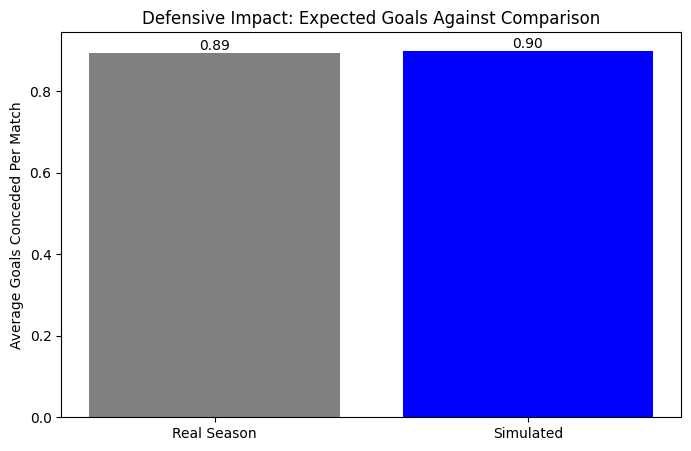


--- 🏟️ Home Win Percentage ---
Real Season Win % at Home: 65.2%
Simulated Win % with New Player: 45.0%

      END OF REPORT


In [56]:
# --- Assemble the dictionary with all fine-tuned models for Player 0 ---
all_models_player0 = {
    "event_type": finetuned_event_type_model_player0,
    "accuracy": finetuned_accuracy_model_player0,
    "goal": finetuned_goal_model_player0,
    "x_location": finetuned_x_location_player0,
    "y_location": finetuned_y_location_player0,
    "timedelta": finetuned_timedelta_model_player0,
    "class_mapping": class_mapping
}

# --- Set Simulation Parameters ---
validation_match_ids_for_sim = val_df['matchId'].unique()
n_simulations = 20
goal_threshold = 0.55
realism_strength = 0.65

# --- Run the Analysis ---
run_player_simulation_analysis(
    real_data_df=df_AEGIS_tunning,
    team_id_to_analyze=id_america,
    simulation_context_df=df_for_player0,
    validation_match_ids=validation_match_ids_for_sim,
    all_finetuned_models=all_models_player0,
    n_matches_to_simulate=n_simulations,
    goal_threshold=goal_threshold,
    realism_strength=realism_strength
)